# Regression Model Comparison on Diabetes Dataset

## Introduction

### Project Objective
This project aims to systematically compare the performance of ten regression models on the Diabetes dataset. By evaluating each model using consistent preprocessing, training, and validation procedures, we will identify which approaches best predict blood glucose levels.


### Dataset Overview
The dataset consists of clinical measurements collected from diabetes patients. It includes the following features:

- **Pregnancies**: Number of times pregnant
- **BloodPressure**: Diastolic blood pressure (mm Hg)
- **SkinThickness**: Triceps skin fold thickness (mm)
- **Insulin**: 2-Hour serum insulin (mu U/ml)
- **BMI**: Body mass index (weight in kg/(height in m)^2)
- **DiabetesPedigreeFunction**: Diabetes pedigree function
- **Age**: Age of the patient (years)

The target variable is:

- **Glucose**: Plasma glucose concentration (mg/dL)


### Imports

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

## Data Loading

### Read CSV

In [70]:
path = 'diabetes.csv'
df = pd.read_csv(path)

### Feature correlations

<Axes: >

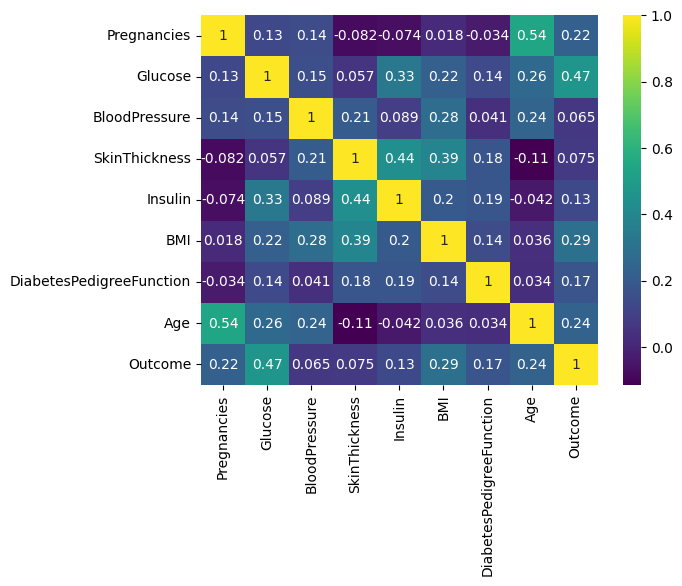

In [71]:
corr = df.corr()
sns.heatmap(corr, cmap='viridis', annot=True)

### Feature distributions

<Figure size 1200x1000 with 0 Axes>

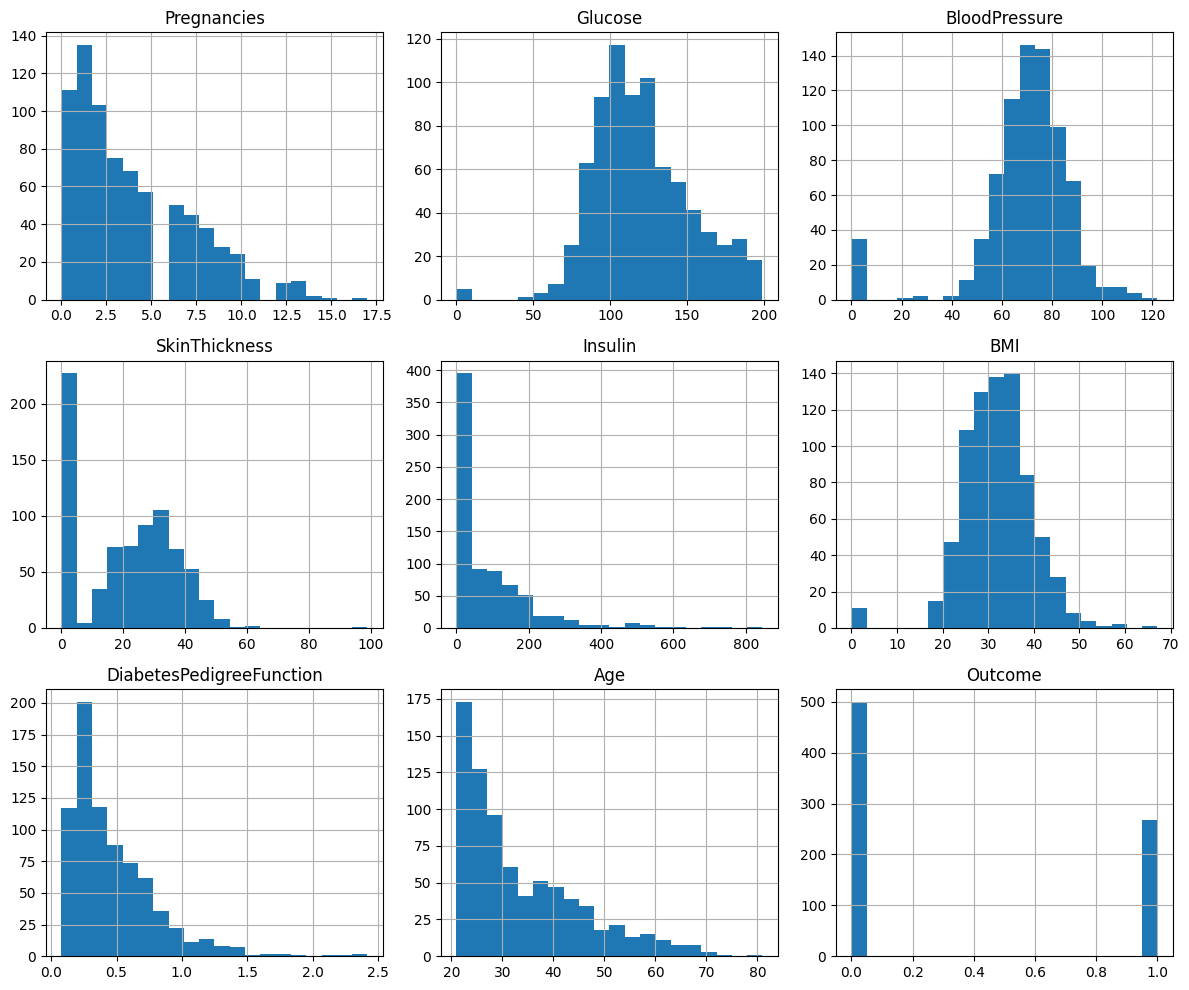

In [72]:
plt.figure(figsize=(12, 10))
df.hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

## Preprocessing

### Convert Zeros to NaN

<Figure size 1200x1000 with 0 Axes>

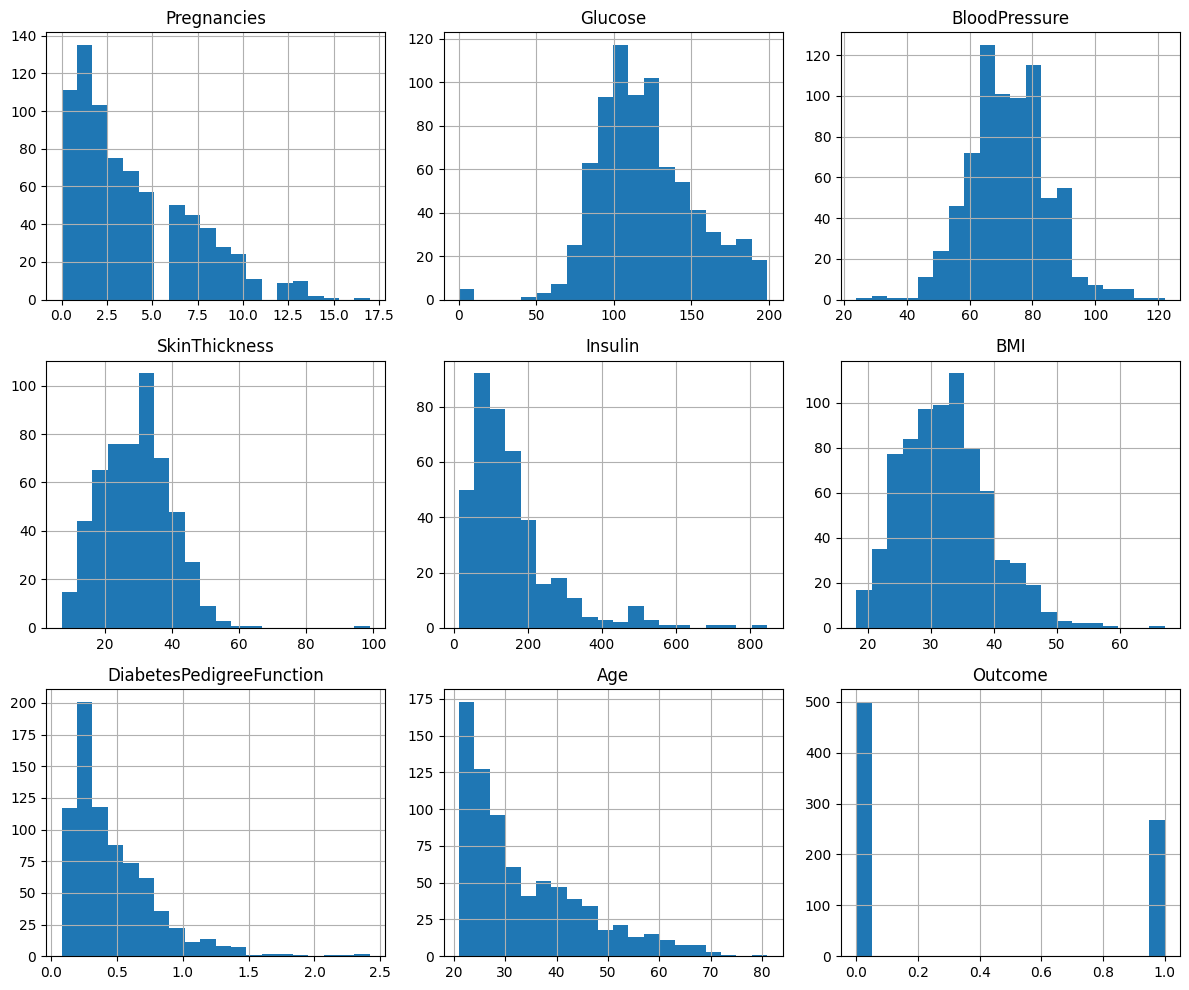

In [73]:
zero_columns = ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_columns] = df[zero_columns].replace(0, np.nan)
plt.figure(figsize=(12, 10))
df.hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

### Outlier Detection

In [89]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

### Train-Test Split

In [90]:
X = df.drop('Glucose', axis=1)
y = df['Glucose']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=715)

### Scaling Features

In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Missing Value Imputation

In [77]:
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

In [78]:
selector = SelectKBest(score_func=f_regression, k=4)
X_train_sel = selector.fit_transform(X_train_imputed, y_train)
X_test_sel = selector.transform(X_test_imputed)
selected_features = X_train.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['BloodPressure', 'Insulin', 'Age', 'Outcome']


In [79]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)
print(f"Number of PCA components: {pca.n_components_}")

Number of PCA components: 4


### Polynomial Feature Generation 

In [80]:
square = PolynomialFeatures(degree=2)
X_poly_train = square.fit_transform(X_train_pca)
X_poly_test = square.transform(X_test_pca)

## Model Training

### Define Models

In [81]:
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': LinearRegression(),
    'KNN Regression': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=715),
    'Random Forest Regression': RandomForestRegressor(random_state=715),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Bayesian Linear Regression': BayesianRidge()
}

### Cross Validation

In [82]:
results = []
for name, model in models.items():
    if name == 'Polynomial Regression':
        X_cv_train = X_poly_train
    else:
        X_cv_train = X_train_pca
    mse_scores = -cross_val_score(model, X_cv_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_cv_train, y_train, cv=5, scoring='r2')
    results.append({
        'Model': name,
        'CV MSE Mean': np.mean(mse_scores),
        'CV MSE Std': np.std(mse_scores),
        'CV R2 Mean': np.mean(r2_scores),
        'CV R2 Std': np.std(r2_scores)
    })
results_df = pd.DataFrame(results)
display(results_df)

,Model,CV MSE Mean,CV MSE Std,CV R2 Mean,CV R2 Std
0,Linear Regression,535.402781,91.962597,0.351705,0.038580
1,Polynomial Regression,538.024536,99.297460,0.350348,0.039313
2,KNN Regression,624.890806,92.296545,0.239227,0.053337
3,Support Vector Regression,589.481471,119.640695,0.289528,0.060897
4,Decision Tree Regression,1153.950429,95.816661,-0.417383,0.126225
5,Random Forest Regression,612.046381,84.468697,0.254831,0.039694
6,Ridge Regression,535.405770,91.967093,0.351698,0.038635
7,Lasso Regression,542.042506,91.230055,0.342749,0.044289
8,Bayesian Linear Regression,535.528105,92.004544,0.351520,0.039059


### Analyzing Cross Validation Results
Based on the cross validation results, the Linear Regression, Ridge Regression, and Bayesian Linear Regression models show the best overall performance, with very close values. All three achieve a CV MSE around 540–541 and a CV R² around 0.344. The standard deviations of these metrics are also low, suggesting stability across folds.
Polynomial Regression performance is slightly worse than standard linear models, indicating that the added complexity may not be justified given the dataset. Models like KNN, SVR, and especially Decision Tree Regression perform significantly worse, with higher MSEs and lower R² scores implying poor generalization or overfitting.
Ridge Regression is the best model for continued development. It performs as well as Linear Regression in terms of accuracy but includes regularization, which helps prevent overfitting and often leads to better generalization.

## Hyperparameter Tuning

In [83]:
param_grid = {
    'alpha': np.logspace(-4, 4, 20)  # From 1e-4 to 1e4
}

ridge = Ridge()

ridge_grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
ridge_grid.fit(X_train_pca, y_train)

print("Best alpha:", ridge_grid.best_params_['alpha'])
print("Best cross-validated MSE:", -ridge_grid.best_score_)


Best alpha: 0.0001
Best cross-validated MSE: 535.4027808374278


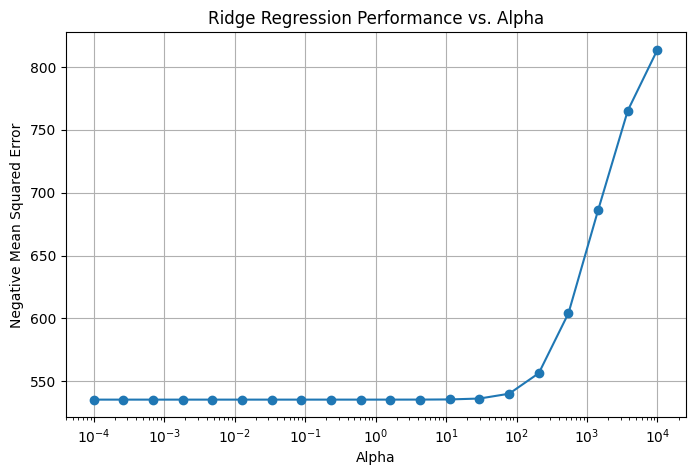

In [84]:
plt.figure(figsize=(8, 5))
plt.semilogx(param_grid['alpha'], -ridge_grid.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error')
plt.title('Ridge Regression Performance vs. Alpha')
plt.grid(True)
plt.show()


## Results

In [85]:
best_ridge = ridge_grid.best_estimator_
best_ridge.fit(X_train_pca, y_train)

y_pred_ridge = best_ridge.predict(X_test_pca)



mse_test = mean_squared_error(y_test, y_pred_ridge)
r2_test = r2_score(y_test, y_pred_ridge)

print("Test MSE:", mse_test)
print("Test R²:", r2_test)


Test MSE: 549.4413346122101
Test R²: 0.36624372509166403
